In [333]:
import IPython
import tensorflow as tf
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.13.0


In [334]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [335]:
data = pd.read_csv('data/prod-licenses.csv')

In [336]:
time.mktime(datetime.datetime.strptime(data['saledate'][0], '%Y-%m-%d %H:%M:%S')\
    .timetuple())



1527884208.0

In [337]:
def saledate_to_timestamp(saledate):
    if not isinstance(saledate, str): return saledate
    return datetime.date.fromisoformat(saledate[:10])

def date_to_weekday(date):
    if not isinstance(date, datetime.date): return date
    return date.timetuple().tm_wday

data['saledate'] = data['saledate'].apply(saledate_to_timestamp)
data['day_of_week'] = data['saledate'].apply(date_to_weekday)

In [338]:
office_guids = [
    "f488ef9b-b814-4f9b-abb4-a49800c75819",
    "de76fe0c-f6df-42e0-8fdc-a37000b6c6e3",
    "d1d14ba1-ef6c-47ce-9bd2-a44200d6498b",
    "3d9d15e0-a4c6-4de5-ad88-a62000ceeccd",
    "c0d10801-0abb-45b4-9820-a41701262ef0",
    "182db722-90e1-465b-a278-a5da00a51cfa",
    "1fe090bc-0e4f-418d-9dbd-a62000ce8992"
]

data_office = data.loc[data['productid'].isin(office_guids)]

# drop 2023 outlier
data_office = data_office.loc[data_office['saledate'] <= datetime.date(2023,1,1)]
data_office['saledate'].array[0]

datetime.date(2018, 6, 1)

In [339]:
# add day of year column, then sin/cos signals
data_office['day_of_year'] = data_office['saledate'].apply(lambda x: x.timetuple().tm_yday)
data_office['year_sin'] = np.sin(data_office['day_of_year'].apply(lambda x: x * (2 * np.pi / 365)))
data_office['year_cos'] = np.cos(data_office['day_of_year'].apply(lambda x: x * (2 * np.pi / 365)))

In [340]:
sale_counts = data_office.groupby(data['saledate'])['activationcount'].count()

grouped_data = pd.DataFrame({'sale_counts': sale_counts})

In [341]:
# Add zeros in data

add_day = datetime.timedelta(days=1)

current_date = sale_counts.index.min()
max_date = sale_counts.index.max()

while current_date < max_date:
    if current_date not in grouped_data.index:
        grouped_data = pd.concat([grouped_data, pd.DataFrame({'sale_counts': 0},index=[current_date])])
    current_date += add_day
    
grouped_data = grouped_data.sort_index()

grouped_data['day_of_week_sin'] = np.sin(grouped_data.index.map(lambda x: x.timetuple().tm_wday * (2 * np.pi / 7)))
grouped_data['day_of_week_cos'] = np.cos(grouped_data.index.map(lambda x: x.timetuple().tm_wday * (2 * np.pi / 7)))
grouped_data['is_weekday'] = grouped_data.index.map(lambda x: 1 if 1 <= x.timetuple().tm_wday <= 5 else 0)

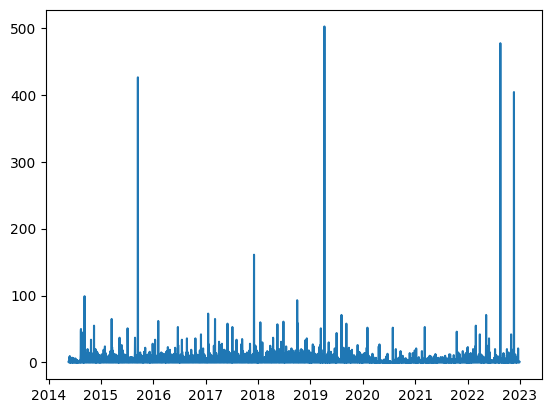

In [342]:
x = grouped_data.index
y = grouped_data['sale_counts'].array

plt.plot(x,y)

Text(0.5, 1.0, 'FFT of License Creations by Day')

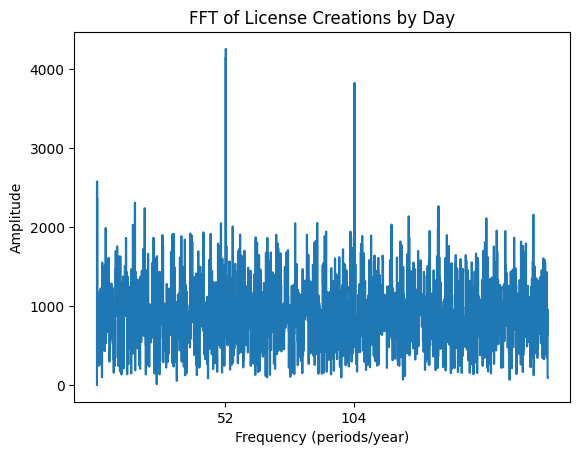

In [343]:
# mean center
grouped_data_centered = grouped_data - grouped_data.mean()

fft = np.abs(np.fft.rfft(grouped_data_centered['sale_counts'].array))

f_per_dataset = np.arange(0,len(fft))
n_samples_d = len(grouped_data_centered)
days_per_year = 365
years_per_dataset = n_samples_d / days_per_year

f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, fft)
plt.xticks([52,104])
plt.xlabel('Frequency (periods/year)')
plt.ylabel('Amplitude')
plt.title('FFT of License Creations by Day')

In [344]:
n = len(grouped_data)
train_df = grouped_data[0:int(n*0.7)]
val_df = grouped_data[int(n*0.7):int(n*0.9)]
test_df = grouped_data[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [345]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [346]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [347]:
def plot(self, model=None, plot_col='sale_counts', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

WindowGenerator.plot = plot

In [348]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [349]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [350]:
single_step_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['sale_counts'])
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['sale_counts']

In [351]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [352]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [353]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val, verbose=0)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
69/69 [==============================] - 1s 8ms/step - loss: 2.5840 - mean_absolute_error: 1.0387 - val_loss: 1.0194 - val_mean_absolute_error: 0.8668
Epoch 2/20
69/69 [==============================] - 1s 7ms/step - loss: 2.3493 - mean_absolute_error: 0.9697 - val_loss: 0.8768 - val_mean_absolute_error: 0.8020
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 2.1554 - mean_absolute_error: 0.9064 - val_loss: 0.7607 - val_mean_absolute_error: 0.7420
Epoch 4/20
69/69 [==============================] - 0s 5ms/step - loss: 1.9923 - mean_absolute_error: 0.8490 - val_loss: 0.6634 - val_mean_absolute_error: 0.6846
Epoch 5/20
69/69 [==============================] - 0s 5ms/step - loss: 1.8526 - mean_absolute_error: 0.7956 - val_loss: 0.5798 - val_mean_absolute_error: 0.6327
Epoch 6/20
69/69 [==============================] - 0s 5ms/step - loss: 1.7317 - mean_absolute_error: 0.7462 - val_loss: 0.5079 - val_mean_absolute_error: 0.5851
Epoch 7/20
69/69 [==========

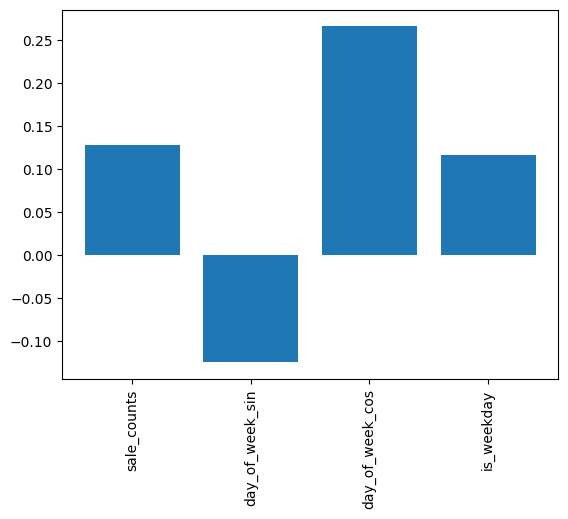

In [354]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [374]:
CONV_WIDTH = 31
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['sale_counts'])

In [375]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

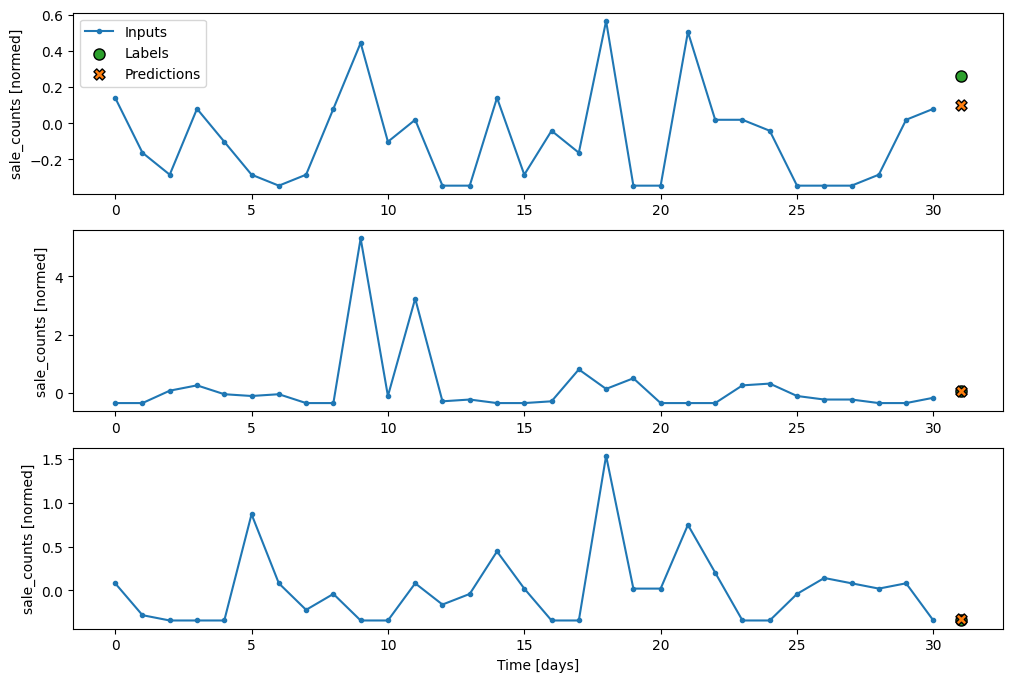

In [376]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, verbose=0)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
conv_window.plot(multi_step_dense)